In [448]:
#!pip install scikeras
#!pip install tensorflow

In [475]:
import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.colors
import matplotlib.pyplot as plt

import numpy as np
import mglearn
import math

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.metrics import Accuracy

from scikeras.wrappers import KerasClassifier
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [492]:
df = pd.read_csv('Shill Bidding Dataset.csv')

## Data Exploration & Understanding

In [3]:
df

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6316,15129,760,l***t,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,1
6317,15137,2481,s***s,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0
6318,15138,2481,h***t,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0
6319,15139,2481,d***d,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0


In [493]:
# Looking at lengths of dataset features
print(f"Length of dataset: {len(set(df.Record_ID))}\n")
print(f"Number of unique values in 'Auction_ID': {len(set(df.Auction_ID))}\n")
print(f"'Class' unique values: {set(df.Class)}\n")
print(f"Number of unique values in 'Auction_Duration': {len(set(df.Auction_Duration))}\n")
print(f"'Successive_Outbidding' unique values: {set(df.Successive_Outbidding)}\n")
print(f"Number of unique values in 'Starting_Price_Average': {len(set(df.Starting_Price_Average))}\n")

Length of dataset: 6321

Number of unique values in 'Auction_ID': 807

'Class' unique values: {0, 1}

Number of unique values in 'Auction_Duration': 5

'Successive_Outbidding' unique values: {0.0, 1.0, 0.5}

Number of unique values in 'Starting_Price_Average': 22



<AxesSubplot:xlabel='Class', ylabel='count'>

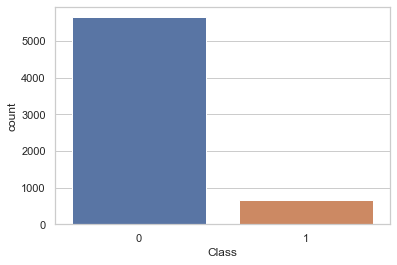

In [10]:
sns.countplot(df['Class'])

<AxesSubplot:xlabel='Successive_Outbidding', ylabel='count'>

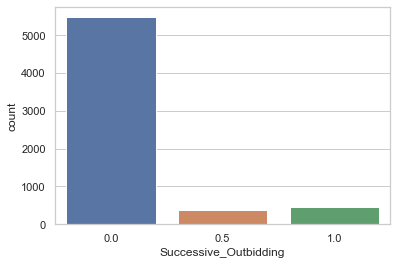

In [11]:
sns.countplot(df['Successive_Outbidding'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Record_ID               6321 non-null   int64  
 1   Auction_ID              6321 non-null   int64  
 2   Bidder_ID               6321 non-null   object 
 3   Bidder_Tendency         6321 non-null   float64
 4   Bidding_Ratio           6321 non-null   float64
 5   Successive_Outbidding   6321 non-null   float64
 6   Last_Bidding            6321 non-null   float64
 7   Auction_Bids            6321 non-null   float64
 8   Starting_Price_Average  6321 non-null   float64
 9   Early_Bidding           6321 non-null   float64
 10  Winning_Ratio           6321 non-null   float64
 11  Auction_Duration        6321 non-null   int64  
 12  Class                   6321 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 642.1+ KB


## Data Preparation

In [13]:
df = df.drop(columns='Bidder_ID')

In [14]:
df

,Record_ID,Auction_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,2,732,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,3,732,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,4,732,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,5,900,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6316,15129,760,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,1
6317,15137,2481,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0
6318,15138,2481,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0
6319,15139,2481,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0


In [15]:
df = df.drop(columns='Early_Bidding')
df = df.drop(columns='Auction_ID')
df = df.drop(columns='Starting_Price_Average')

In [16]:
df

,Record_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Winning_Ratio,Auction_Duration,Class
0,1,0.200000,0.400000,0.0,0.000028,0.000000,0.666667,5,0
1,2,0.024390,0.200000,0.0,0.013123,0.000000,0.944444,5,0
2,3,0.142857,0.200000,0.0,0.003042,0.000000,1.000000,5,0
3,4,0.100000,0.200000,0.0,0.097477,0.000000,1.000000,5,0
4,5,0.051282,0.222222,0.0,0.001318,0.000000,0.500000,7,0
...,...,...,...,...,...,...,...,...,...
6316,15129,0.333333,0.160000,1.0,0.738557,0.280000,0.888889,3,1
6317,15137,0.030612,0.130435,0.0,0.005754,0.217391,0.878788,7,0
6318,15138,0.055556,0.043478,0.0,0.015663,0.217391,0.000000,7,0
6319,15139,0.076923,0.086957,0.0,0.068694,0.217391,0.000000,7,0


### Scaling Data

In [17]:
# Scaling Data
df_scaled = preprocessing.scale(df)

# Turning df_scaled from NumPy array to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Putting values that shouldn't be scaled back to their original
df_scaled['Record_ID'] = df['Record_ID']
df_scaled['Successive_Outbidding'] = df['Successive_Outbidding']
df_scaled['Auction_Duration'] = df['Auction_Duration']
df_scaled['Class'] = df['Class']

df1 = df_scaled

In [18]:
df1

,Record_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Winning_Ratio,Auction_Duration,Class
0,1,0.291571,2.070638,0.0,-1.218447,-0.907433,0.684785,5,0
1,2,-0.599542,0.549957,0.0,-1.183993,-0.907433,1.321104,5,0
2,3,0.001606,0.549957,0.0,-1.210517,-0.907433,1.448368,5,0
3,4,-0.215868,0.549957,0.0,-0.962047,-0.907433,1.448368,5,0
4,5,-0.463082,0.718921,0.0,-1.215053,-0.907433,0.302994,7,0
...,...,...,...,...,...,...,...,...,...
6316,15129,0.968156,0.245821,1.0,0.724708,0.189609,1.193840,3,1
6317,15137,-0.567969,0.021024,0.0,-1.203380,-0.055692,1.170701,7,0
6318,15138,-0.441397,-0.640141,0.0,-1.177309,-0.055692,-0.842379,7,0
6319,15139,-0.332970,-0.309559,0.0,-1.037779,-0.055692,-0.842379,7,0


In [19]:
# Min_max
minmax = MinMaxScaler().fit(df)
minmax = minmax.transform(df)

dataset = pd.DataFrame(minmax, columns=df.columns)

dataset['Record_ID'] = df['Record_ID']
dataset['Successive_Outbidding'] = df['Successive_Outbidding']
dataset['Auction_Duration'] = df['Auction_Duration']
dataset['Class'] = df['Class']

In [20]:
dataset

,Record_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Winning_Ratio,Auction_Duration,Class
0,1,0.200000,0.392857,0.0,0.000028,0.000000,0.666667,5,0
1,2,0.024390,0.190476,0.0,0.013124,0.000000,0.944444,5,0
2,3,0.142857,0.190476,0.0,0.003042,0.000000,1.000000,5,0
3,4,0.100000,0.190476,0.0,0.097487,0.000000,1.000000,5,0
4,5,0.051282,0.212963,0.0,0.001318,0.000000,0.500000,7,0
...,...,...,...,...,...,...,...,...,...
6316,15129,0.333333,0.150000,1.0,0.738631,0.355224,0.888889,3,1
6317,15137,0.030612,0.120083,0.0,0.005755,0.275795,0.878788,7,0
6318,15138,0.055556,0.032091,0.0,0.015665,0.275795,0.000000,7,0
6319,15139,0.076923,0.076087,0.0,0.068701,0.275795,0.000000,7,0


In [21]:
df

,Record_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Winning_Ratio,Auction_Duration,Class
0,1,0.200000,0.400000,0.0,0.000028,0.000000,0.666667,5,0
1,2,0.024390,0.200000,0.0,0.013123,0.000000,0.944444,5,0
2,3,0.142857,0.200000,0.0,0.003042,0.000000,1.000000,5,0
3,4,0.100000,0.200000,0.0,0.097477,0.000000,1.000000,5,0
4,5,0.051282,0.222222,0.0,0.001318,0.000000,0.500000,7,0
...,...,...,...,...,...,...,...,...,...
6316,15129,0.333333,0.160000,1.0,0.738557,0.280000,0.888889,3,1
6317,15137,0.030612,0.130435,0.0,0.005754,0.217391,0.878788,7,0
6318,15138,0.055556,0.043478,0.0,0.015663,0.217391,0.000000,7,0
6319,15139,0.076923,0.086957,0.0,0.068694,0.217391,0.000000,7,0


## Modelling

### Making splits

In [22]:
# Creating our features label and target variable
X = df.iloc[:,0:8]
y = df.iloc[:,-1]

In [23]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [24]:
X.head()

,Record_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Winning_Ratio,Auction_Duration
0,1,0.200000,0.400000,0.0,0.000028,0.0,0.666667,5
1,2,0.024390,0.200000,0.0,0.013123,0.0,0.944444,5
2,3,0.142857,0.200000,0.0,0.003042,0.0,1.000000,5
3,4,0.100000,0.200000,0.0,0.097477,0.0,1.000000,5
4,5,0.051282,0.222222,0.0,0.001318,0.0,0.500000,7


In [25]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

### SVM Modelling

#### Without Hyper-paramter Tuning using unscaled dataset

In [26]:
# train the model on train set
svm_model = SVC()
svm_model.fit(X_train, y_train)
  
# print prediction results
predictions = svm_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1728
           1       0.00      0.00      0.00       169

    accuracy                           0.91      1897
   macro avg       0.46      0.50      0.48      1897
weighted avg       0.83      0.91      0.87      1897



<AxesSubplot:>

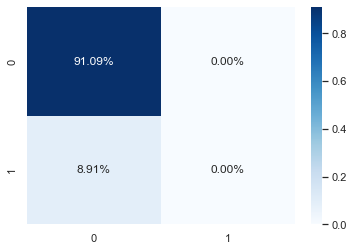

In [38]:
cf_matrix_svm_untuned = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix_svm_untuned/np.sum(cf_matrix_svm_untuned), annot=True, fmt='.2%', cmap='Blues')

#### With Hyper-paramter Tuning (GridSearchCV) using unscaled dataset

In [27]:
%%time

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.885 total time=   0.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.922 total time=  18.8s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.938 total time=  31.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.914 total time=  18.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.919 total time=  11.8s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.919 total time=  37.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.886 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

[CV 2/5] END .........C=10, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 3/5] END .........C=10, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 4/5] END .........C=10, gamma=1, kernel=rbf;, score=0.885 total time=   0.5s
[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 1/5] END ......C=10, gamma=1, kernel=linear;, score=0.924 total time=  21.9s
[CV 2/5] END ......C=10, gamma=1, kernel=linear;, score=0.939 total time=  15.8s
[CV 3/5] END ......C=10, gamma=1, kernel=linear;, score=0.918 total time=  17.7s
[CV 4/5] END ......C=10, gamma=1, kernel=linear;, score=0.921 total time=  15.1s
[CV 5/5] END ......C=10, gamma=1, kernel=linear;, score=0.919 total time=  56.0s
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.846 total time=   0.5s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.5s
[CV 3/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.846 total time=   0.5s
[CV 4/5] END .......C=10, ga

[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.885 total time=   0.5s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.886 total time=   0.5s
[CV 1/5] END ....C=1000, gamma=1, kernel=linear;, score=0.919 total time=  13.9s
[CV 2/5] END ....C=1000, gamma=1, kernel=linear;, score=0.939 total time=  14.9s
[CV 3/5] END ....C=1000, gamma=1, kernel=linear;, score=0.916 total time=  13.7s
[CV 4/5] END ....C=1000, gamma=1, kernel=linear;, score=0.921 total time=  22.6s
[CV 5/5] END ....C=1000, gamma=1, kernel=linear;, score=0.919 total time=  53.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.846 total time=   0.5s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.842 total time=   0.5s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.846 total time=   0.5s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.851 total time=   0.5s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.854 total time=   0.5s
[CV 1/5] END ..C=1000, gamma

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [28]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100, 'gamma': 1, 'kernel': 'linear'}
SVC(C=100, gamma=1, kernel='linear')


In [29]:
grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1728
           1       0.77      0.45      0.57       169

    accuracy                           0.94      1897
   macro avg       0.86      0.72      0.77      1897
weighted avg       0.93      0.94      0.93      1897



<AxesSubplot:>

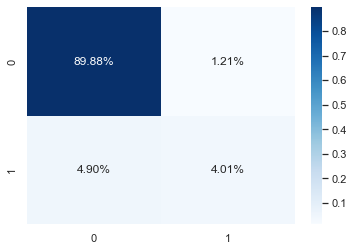

In [37]:
cf_matrix_svm_tuned = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cf_matrix_svm_tuned/np.sum(cf_matrix_svm_tuned), annot=True, fmt='.2%', cmap='Blues')

#### Creating SVM using scaled dataset

In [45]:
# Creating our features label and target variable for scale dataset
X1 = df1.iloc[:,0:8]
y1 = df1.iloc[:,-1]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.30, random_state=101)

In [46]:
svm_model = SVC(C=100, gamma=1, kernel='linear')
svm_model.fit(X_train_1, y_train_1)
  
# print prediction results
predictions = svm_model.predict(X_test_1)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1728
           1       0.91      0.81      0.86       169

    accuracy                           0.98      1897
   macro avg       0.94      0.90      0.92      1897
weighted avg       0.98      0.98      0.98      1897



<AxesSubplot:>

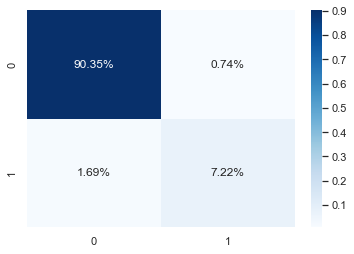

In [47]:
cf_matrix_svm_untuned = confusion_matrix(y_test_1, predictions)
sns.heatmap(cf_matrix_svm_untuned/np.sum(cf_matrix_svm_untuned), annot=True, fmt='.2%', cmap='Blues')

#### Creating SVM using minmax scaled dataset

In [48]:
# Creating our features label and target variable
X2 = dataset.iloc[:,0:8]
y2 = dataset.iloc[:,-1]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.30, random_state=101)

In [49]:
svm_model = SVC(C=100, gamma=1, kernel='linear')
svm_model.fit(X_train_2, y_train_2)
  
# print prediction results
predictions = svm_model.predict(X_test_2)
print(classification_report(y_test_2, predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1728
           1       0.77      0.46      0.57       169

    accuracy                           0.94      1897
   macro avg       0.86      0.72      0.77      1897
weighted avg       0.93      0.94      0.93      1897



<AxesSubplot:>

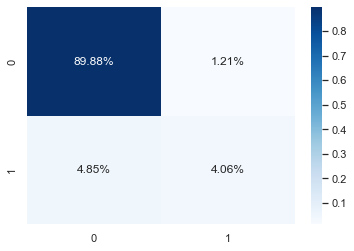

In [50]:
cf_matrix_svm_untuned = confusion_matrix(y_test_2, predictions)
sns.heatmap(cf_matrix_svm_untuned/np.sum(cf_matrix_svm_untuned), annot=True, fmt='.2%', cmap='Blues')

#### Making scale DataFrame into df

In [51]:
# Making the DataFrame which used preprocessing.scale into the main DataFrame
df = df1

#### Making scaled training and test data into main test and train data

In [52]:
X = X1
y = y1

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

### Getting scale SVM accuracy scores

In [79]:
# train the model on train set
svm_model = SVC(C=100, gamma=1, kernel='linear')
svm_model.fit(X_train, y_train)
  
# print prediction results
svm_predictions = svm_model.predict(X_test)
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1728
           1       0.91      0.81      0.86       169

    accuracy                           0.98      1897
   macro avg       0.94      0.90      0.92      1897
weighted avg       0.98      0.98      0.98      1897



<AxesSubplot:>

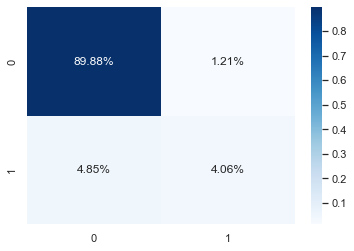

In [80]:
cf_matrix_svm_tuned_scale = confusion_matrix(y_test, svm_predictions)
sns.heatmap(cf_matrix_svm_untuned/np.sum(cf_matrix_svm_tuned_scale), annot=True, fmt='.2%', cmap='Blues')

### Naive Bayes Modelling

#### Without Hyper-parameter Tuning

In [55]:
GNB = GaussianNB()

GNB.fit(X_train, y_train)

GaussianNB()

In [56]:
# print prediction results
predictions = GNB.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1728
           1       0.74      0.98      0.84       169

    accuracy                           0.97      1897
   macro avg       0.87      0.97      0.91      1897
weighted avg       0.98      0.97      0.97      1897



<AxesSubplot:>

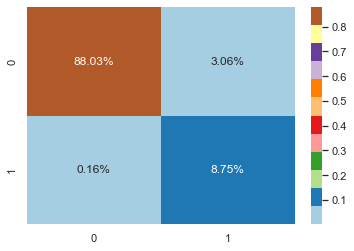

In [64]:
cf_matrix_gnb_untuned = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix_gnb_untuned/np.sum(cf_matrix_gnb_untuned), annot=True, fmt='.2%', cmap='Paired')

#### With Hyper-parameter Tuning using GridSearchCV

In [81]:
%%time

# defining parameter range
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)} 
  
grid = GridSearchCV(GaussianNB(), param_grid, refit = True, verbose = 3, cv=10)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10] END ................var_smoothing=1.0;, score=0.885 total time=   0.0s
[CV 2/10] END ................var_smoothing=1.0;, score=0.885 total time=   0.0s
[CV 3/10] END ................var_smoothing=1.0;, score=0.885 total time=   0.0s
[CV 4/10] END ................var_smoothing=1.0;, score=0.885 total time=   0.0s
[CV 5/10] END ................var_smoothing=1.0;, score=0.887 total time=   0.0s
[CV 6/10] END ................var_smoothing=1.0;, score=0.887 total time=   0.0s
[CV 7/10] END ................var_smoothing=1.0;, score=0.887 total time=   0.0s
[CV 8/10] END ................var_smoothing=1.0;, score=0.887 total time=   0.0s
[CV 9/10] END ................var_smoothing=1.0;, score=0.885 total time=   0.0s
[CV 10/10] END ...............var_smoothing=1.0;, score=0.885 total time=   0.0s
[CV 1/10] END .var_smoothing=0.8111308307896871;, score=0.885 total time=   0.0s
[CV 2/10] END .var_smoothing=0.8111308307896

[CV 10/10] END ...............var_smoothing=0.1;, score=0.885 total time=   0.0s
[CV 1/10] END var_smoothing=0.08111308307896872;, score=0.885 total time=   0.0s
[CV 2/10] END var_smoothing=0.08111308307896872;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=0.08111308307896872;, score=0.885 total time=   0.0s
[CV 4/10] END var_smoothing=0.08111308307896872;, score=0.885 total time=   0.0s
[CV 5/10] END var_smoothing=0.08111308307896872;, score=0.887 total time=   0.0s
[CV 6/10] END var_smoothing=0.08111308307896872;, score=0.887 total time=   0.0s
[CV 7/10] END var_smoothing=0.08111308307896872;, score=0.887 total time=   0.0s
[CV 8/10] END var_smoothing=0.08111308307896872;, score=0.887 total time=   0.0s
[CV 9/10] END var_smoothing=0.08111308307896872;, score=0.885 total time=   0.0s
[CV 10/10] END var_smoothing=0.08111308307896872;, score=0.885 total time=   0.0s
[CV 1/10] END .var_smoothing=0.0657933224657568;, score=0.885 total time=   0.0s
[CV 2/10] END .var_smoothin

[CV 1/10] END var_smoothing=0.006579332246575682;, score=0.885 total time=   0.0s
[CV 2/10] END var_smoothing=0.006579332246575682;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=0.006579332246575682;, score=0.885 total time=   0.0s
[CV 4/10] END var_smoothing=0.006579332246575682;, score=0.885 total time=   0.0s
[CV 5/10] END var_smoothing=0.006579332246575682;, score=0.887 total time=   0.0s
[CV 6/10] END var_smoothing=0.006579332246575682;, score=0.887 total time=   0.0s
[CV 7/10] END var_smoothing=0.006579332246575682;, score=0.887 total time=   0.0s
[CV 8/10] END var_smoothing=0.006579332246575682;, score=0.887 total time=   0.0s
[CV 9/10] END var_smoothing=0.006579332246575682;, score=0.885 total time=   0.0s
[CV 10/10] END var_smoothing=0.006579332246575682;, score=0.885 total time=   0.0s
[CV 1/10] END var_smoothing=0.005336699231206307;, score=0.885 total time=   0.0s
[CV 2/10] END var_smoothing=0.005336699231206307;, score=0.885 total time=   0.0s
[CV 3/10] END v

[CV 2/10] END var_smoothing=0.0005336699231206307;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=0.0005336699231206307;, score=0.885 total time=   0.0s
[CV 4/10] END var_smoothing=0.0005336699231206307;, score=0.885 total time=   0.0s
[CV 5/10] END var_smoothing=0.0005336699231206307;, score=0.887 total time=   0.0s
[CV 6/10] END var_smoothing=0.0005336699231206307;, score=0.887 total time=   0.0s
[CV 7/10] END var_smoothing=0.0005336699231206307;, score=0.887 total time=   0.0s
[CV 8/10] END var_smoothing=0.0005336699231206307;, score=0.887 total time=   0.0s
[CV 9/10] END var_smoothing=0.0005336699231206307;, score=0.885 total time=   0.0s
[CV 10/10] END var_smoothing=0.0005336699231206307;, score=0.885 total time=   0.0s
[CV 1/10] END var_smoothing=0.0004328761281083057;, score=0.885 total time=   0.0s
[CV 2/10] END var_smoothing=0.0004328761281083057;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=0.0004328761281083057;, score=0.885 total time=   0.0s
[CV

[CV 2/10] END var_smoothing=4.328761281083062e-05;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=4.328761281083062e-05;, score=0.885 total time=   0.0s
[CV 4/10] END var_smoothing=4.328761281083062e-05;, score=0.885 total time=   0.0s
[CV 5/10] END var_smoothing=4.328761281083062e-05;, score=0.887 total time=   0.0s
[CV 6/10] END var_smoothing=4.328761281083062e-05;, score=0.887 total time=   0.0s
[CV 7/10] END var_smoothing=4.328761281083062e-05;, score=0.887 total time=   0.0s
[CV 8/10] END var_smoothing=4.328761281083062e-05;, score=0.887 total time=   0.0s
[CV 9/10] END var_smoothing=4.328761281083062e-05;, score=0.885 total time=   0.0s
[CV 10/10] END var_smoothing=4.328761281083062e-05;, score=0.885 total time=   0.0s
[CV 1/10] END var_smoothing=3.511191734215127e-05;, score=0.885 total time=   0.0s
[CV 2/10] END var_smoothing=3.511191734215127e-05;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=3.511191734215127e-05;, score=0.885 total time=   0.0s
[CV

[CV 3/10] END var_smoothing=3.5111917342151275e-06;, score=0.885 total time=   0.0s
[CV 4/10] END var_smoothing=3.5111917342151275e-06;, score=0.885 total time=   0.0s
[CV 5/10] END var_smoothing=3.5111917342151275e-06;, score=0.887 total time=   0.0s
[CV 6/10] END var_smoothing=3.5111917342151275e-06;, score=0.887 total time=   0.0s
[CV 7/10] END var_smoothing=3.5111917342151275e-06;, score=0.887 total time=   0.0s
[CV 8/10] END var_smoothing=3.5111917342151275e-06;, score=0.887 total time=   0.0s
[CV 9/10] END var_smoothing=3.5111917342151275e-06;, score=0.885 total time=   0.0s
[CV 10/10] END var_smoothing=3.5111917342151275e-06;, score=0.885 total time=   0.0s
[CV 1/10] END var_smoothing=2.848035868435799e-06;, score=0.885 total time=   0.0s
[CV 2/10] END var_smoothing=2.848035868435799e-06;, score=0.885 total time=   0.0s
[CV 3/10] END var_smoothing=2.848035868435799e-06;, score=0.885 total time=   0.0s
[CV 4/10] END var_smoothing=2.848035868435799e-06;, score=0.885 total time=   

[CV 4/10] END var_smoothing=2.848035868435799e-07;, score=0.889 total time=   0.0s
[CV 5/10] END var_smoothing=2.848035868435799e-07;, score=0.887 total time=   0.0s
[CV 6/10] END var_smoothing=2.848035868435799e-07;, score=0.887 total time=   0.0s
[CV 7/10] END var_smoothing=2.848035868435799e-07;, score=0.885 total time=   0.0s
[CV 8/10] END var_smoothing=2.848035868435799e-07;, score=0.889 total time=   0.0s
[CV 9/10] END var_smoothing=2.848035868435799e-07;, score=0.889 total time=   0.0s
[CV 10/10] END var_smoothing=2.848035868435799e-07;, score=0.889 total time=   0.0s
[CV 1/10] END var_smoothing=2.310129700083158e-07;, score=0.887 total time=   0.0s
[CV 2/10] END var_smoothing=2.310129700083158e-07;, score=0.896 total time=   0.0s
[CV 3/10] END var_smoothing=2.310129700083158e-07;, score=0.887 total time=   0.0s
[CV 4/10] END var_smoothing=2.310129700083158e-07;, score=0.889 total time=   0.0s
[CV 5/10] END var_smoothing=2.310129700083158e-07;, score=0.891 total time=   0.0s
[CV

[CV 4/10] END var_smoothing=2.310129700083158e-08;, score=0.930 total time=   0.0s
[CV 5/10] END var_smoothing=2.310129700083158e-08;, score=0.928 total time=   0.0s
[CV 6/10] END var_smoothing=2.310129700083158e-08;, score=0.937 total time=   0.0s
[CV 7/10] END var_smoothing=2.310129700083158e-08;, score=0.910 total time=   0.0s
[CV 8/10] END var_smoothing=2.310129700083158e-08;, score=0.946 total time=   0.0s
[CV 9/10] END var_smoothing=2.310129700083158e-08;, score=0.928 total time=   0.0s
[CV 10/10] END var_smoothing=2.310129700083158e-08;, score=0.919 total time=   0.0s
[CV 1/10] END var_smoothing=1.873817422860383e-08;, score=0.939 total time=   0.0s
[CV 2/10] END var_smoothing=1.873817422860383e-08;, score=0.923 total time=   0.0s
[CV 3/10] END var_smoothing=1.873817422860383e-08;, score=0.928 total time=   0.0s
[CV 4/10] END var_smoothing=1.873817422860383e-08;, score=0.935 total time=   0.0s
[CV 5/10] END var_smoothing=1.873817422860383e-08;, score=0.928 total time=   0.0s
[CV

[CV 5/10] END var_smoothing=1.873817422860387e-09;, score=0.950 total time=   0.0s
[CV 6/10] END var_smoothing=1.873817422860387e-09;, score=0.977 total time=   0.0s
[CV 7/10] END var_smoothing=1.873817422860387e-09;, score=0.948 total time=   0.0s
[CV 8/10] END var_smoothing=1.873817422860387e-09;, score=0.971 total time=   0.0s
[CV 9/10] END var_smoothing=1.873817422860387e-09;, score=0.962 total time=   0.0s
[CV 10/10] END var_smoothing=1.873817422860387e-09;, score=0.962 total time=   0.0s
[CV 1/10] END var_smoothing=1.519911082952933e-09;, score=0.968 total time=   0.0s
[CV 2/10] END var_smoothing=1.519911082952933e-09;, score=0.968 total time=   0.0s
[CV 3/10] END var_smoothing=1.519911082952933e-09;, score=0.966 total time=   0.0s
[CV 4/10] END var_smoothing=1.519911082952933e-09;, score=0.962 total time=   0.0s
[CV 5/10] END var_smoothing=1.519911082952933e-09;, score=0.957 total time=   0.0s
[CV 6/10] END var_smoothing=1.519911082952933e-09;, score=0.977 total time=   0.0s
[CV

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

In [82]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'var_smoothing': 1e-09}
GaussianNB()


In [83]:
GNB_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, GNB_predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1728
           1       0.74      0.98      0.84       169

    accuracy                           0.97      1897
   macro avg       0.87      0.97      0.91      1897
weighted avg       0.98      0.97      0.97      1897



<AxesSubplot:>

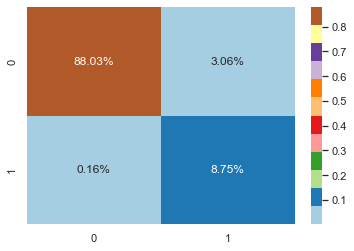

In [84]:
cf_matrix_gnb_tuned = confusion_matrix(y_test, GNB_predictions)
sns.heatmap(cf_matrix_gnb_tuned/np.sum(cf_matrix_gnb_tuned), annot=True, fmt='.2%', cmap='Paired')

### Clustering Model

#### K-Means Clustering

In [130]:
# Create an object using StandardScaler()
scaler = StandardScaler()
scaler.fit(X)

# Standardized the X labels
X_scaled = scaler.transform(X)

# keep the first two principal components of the data
pca = PCA(n_components = 2)

# fit PCA model to shill bidding data
principalComponents_bidding = pca.fit(X_scaled)

# transform data onto the first two principal components
X_pca = pca.transform(X)

print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (6321, 8)
Reduced shape: (6321, 2)


In [131]:
X_scaled

array([[-1.72642414e+00,  2.91570792e-01,  2.07063786e+00, ...,
        -9.07432881e-01,  6.84785358e-01,  1.56058278e-01],
       [-1.72619502e+00, -5.99541854e-01,  5.49956797e-01, ...,
        -9.07432881e-01,  1.32110381e+00,  1.56058278e-01],
       [-1.72596589e+00,  1.60556670e-03,  5.49956797e-01, ...,
        -9.07432881e-01,  1.44836750e+00,  1.56058278e-01],
       ...,
       [ 1.74185372e+00, -4.41396861e-01, -6.40141428e-01, ...,
        -5.56922889e-02, -8.42378931e-01,  9.66945555e-01],
       [ 1.74208285e+00, -3.32969695e-01, -3.09558586e-01, ...,
        -5.56922889e-02, -8.42378931e-01,  9.66945555e-01],
       [ 1.74322848e+00, -6.40120753e-01, -6.40141428e-01, ...,
        -5.56922889e-02, -8.42378931e-01,  9.66945555e-01]])

Text(0, 0.5, 'Second principal component')

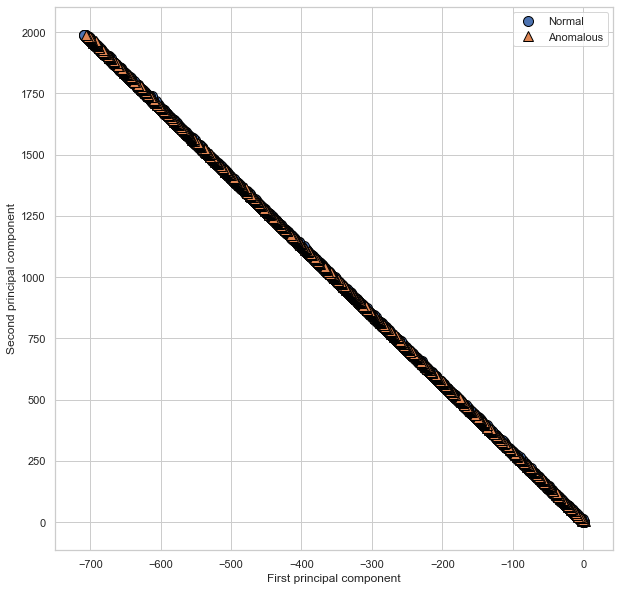

In [174]:
# plot first vs. second principal component, colored by class
plt.figure(figsize = (10, 10))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], df.Class)
plt.legend(["Normal", "Anomalous"])
#plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

In [157]:
kmeans_bids = KMeans(n_clusters = 2)
kmeans_bids.fit(X)
C = kmeans_bids.labels_
C.shape
assign_bids = C.reshape(-1, 1)

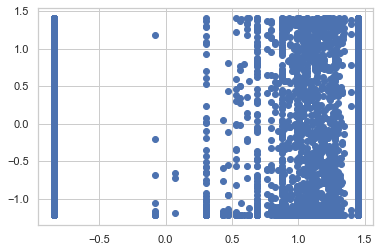

In [158]:
plt.scatter(X['Winning_Ratio'], X['Last_Bidding'])
plt.title('')
plt.show()

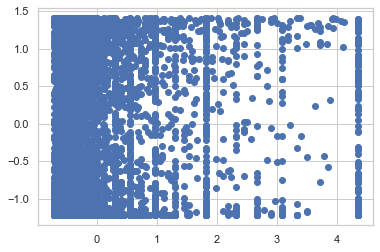

In [159]:
plt.scatter(X['Bidder_Tendency'], X['Last_Bidding'])
plt.title('')
plt.show()

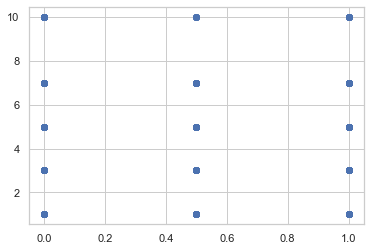

In [160]:
plt.scatter(X['Successive_Outbidding'], X['Auction_Duration'])
plt.title('')
plt.show()

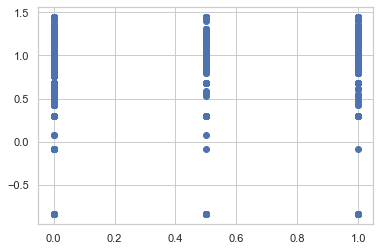

In [161]:
plt.scatter(X['Successive_Outbidding'], X['Winning_Ratio'])
plt.title('')
plt.show()

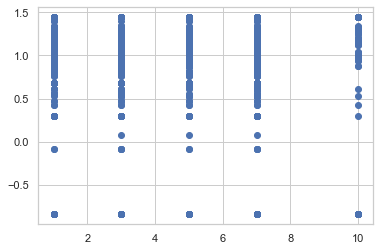

In [162]:
plt.scatter(X['Auction_Duration'], X['Winning_Ratio'])
plt.title('')
plt.show()

In [163]:
# To plot the cluster data, consider two columns
X1 = X['Successive_Outbidding']
X2 = X['Auction_Duration']

# Transform into numpy array
X11 = X1[:, np.newaxis]
X22 = X2[:, np.newaxis]

# Display rows and columns of the arrays
X11.shape, X22.shape, assign_bids.shape

((6321, 1), (6321, 1), (6321, 1))

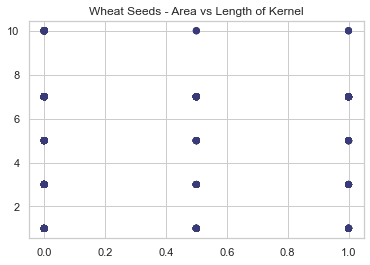

In [164]:
plt.scatter(X11, X22, c = assign_bids, cmap = 'tab20b')
plt.title('Wheat Seeds - Area vs Length of Kernel')
plt.show()

#### K-Means without tuning

In [166]:
kmeans_bids_2 = KMeans(n_clusters = 2)
kmeans_bids_2.fit(X_pca)
C = kmeans_bids_2.labels_
C.shape
assign_bids = C.reshape(-1, 1)

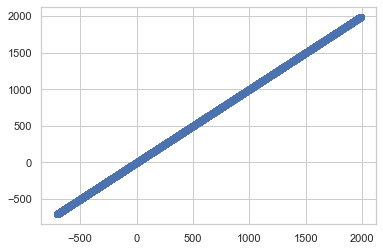

In [167]:
plt.scatter(X_pca, X_pca)
plt.title('')
plt.show()

In [168]:
# To plot the cluster data, consider two columns
X1 = X_pca[:,0]
X2 = X_pca[:,1]

# Transform into numpy array
X11 = X1[:, np.newaxis]
X22 = X2[:, np.newaxis]

# Display rows and columns of the arrays
X11.shape, X22.shape, assign_bids.shape

((6321, 1), (6321, 1), (6321, 1))

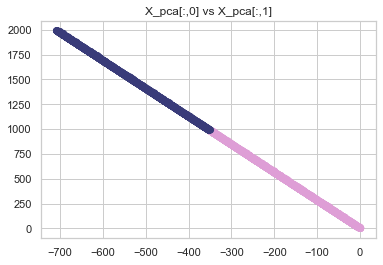

In [170]:
plt.scatter(X11, X22, c = assign_bids, cmap = 'tab20b')
plt.title('X_pca[:,0] vs X_pca[:,1]')
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.51      0.65      5646
           1       0.11      0.51      0.18       675

    accuracy                           0.51      6321
   macro avg       0.50      0.51      0.41      6321
weighted avg       0.81      0.51      0.60      6321



<AxesSubplot:>

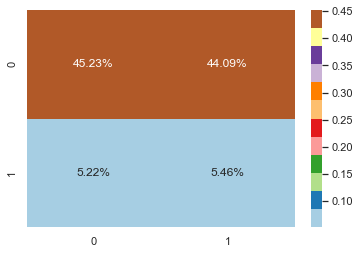

In [180]:
# print prediction results
KMeans_predictions = kmeans_bids_2.predict(X_pca)
print(classification_report(y, KMeans_predictions))

cf_matrix_kmeans = confusion_matrix(y, KMeans_predictions)
sns.heatmap(cf_matrix_kmeans/np.sum(cf_matrix_kmeans), annot=True, fmt='.2%', cmap='Paired')

#### K-Means with tuning using GridSearchCV

In [181]:
%%time

# defining parameter range
param_grid = {'n_clusters': range(2, 300)} 
  
grid = GridSearchCV(KMeans(), param_grid, refit = True, verbose = 3, cv=10)

grid.fit(X_pca)
C = grid.labels_
C.shape
assign_bids = C.reshape(-1, 1)

# fitting the model for grid search
grid.fit(assign_bids)

Fitting 10 folds for each of 298 candidates, totalling 2980 fits
[CV 1/10] END ............n_clusters=2;, score=-208548300.826 total time=   0.1s
[CV 2/10] END .............n_clusters=2;, score=-57110010.350 total time=   0.0s
[CV 3/10] END ..............n_clusters=2;, score=-2488340.931 total time=   0.0s
[CV 4/10] END .............n_clusters=2;, score=-60925802.813 total time=   0.0s
[CV 5/10] END ............n_clusters=2;, score=-166773271.265 total time=   0.0s
[CV 6/10] END ............n_clusters=2;, score=-166640808.458 total time=   0.0s
[CV 7/10] END .............n_clusters=2;, score=-60162315.546 total time=   0.0s
[CV 8/10] END ..............n_clusters=2;, score=-2476101.680 total time=   0.0s
[CV 9/10] END .............n_clusters=2;, score=-56411455.217 total time=   0.0s
[CV 10/10] END ...........n_clusters=2;, score=-217817738.246 total time=   0.0s
[CV 1/10] END ............n_clusters=3;, score=-119783986.890 total time=   0.1s
[CV 2/10] END ..............n_clusters=3;, s

[CV 3/10] END ............n_clusters=12;, score=-12188159.416 total time=   0.1s
[CV 4/10] END ............n_clusters=12;, score=-12118992.718 total time=   0.1s
[CV 5/10] END ............n_clusters=12;, score=-11888493.711 total time=   0.1s
[CV 6/10] END ............n_clusters=12;, score=-10667668.478 total time=   0.1s
[CV 7/10] END ............n_clusters=12;, score=-10046552.020 total time=   0.1s
[CV 8/10] END ............n_clusters=12;, score=-12234045.650 total time=   0.1s
[CV 9/10] END ............n_clusters=12;, score=-13835203.834 total time=   0.1s
[CV 10/10] END ...........n_clusters=12;, score=-26071230.489 total time=   0.1s
[CV 1/10] END ............n_clusters=13;, score=-21576128.056 total time=   0.1s
[CV 2/10] END ............n_clusters=13;, score=-13170046.630 total time=   0.1s
[CV 3/10] END ............n_clusters=13;, score=-10497857.042 total time=   0.1s
[CV 4/10] END ............n_clusters=13;, score=-10158180.602 total time=   0.1s
[CV 5/10] END ............n_

[CV 5/10] END .............n_clusters=22;, score=-6474473.771 total time=   0.1s
[CV 6/10] END .............n_clusters=22;, score=-6138496.463 total time=   0.1s
[CV 7/10] END .............n_clusters=22;, score=-6689999.827 total time=   0.1s
[CV 8/10] END .............n_clusters=22;, score=-5770193.104 total time=   0.1s
[CV 9/10] END .............n_clusters=22;, score=-7003139.628 total time=   0.1s
[CV 10/10] END ...........n_clusters=22;, score=-15307663.238 total time=   0.2s
[CV 1/10] END ............n_clusters=23;, score=-14367293.794 total time=   0.1s
[CV 2/10] END .............n_clusters=23;, score=-5772223.968 total time=   0.1s
[CV 3/10] END .............n_clusters=23;, score=-6095115.309 total time=   0.1s
[CV 4/10] END .............n_clusters=23;, score=-5579684.055 total time=   0.1s
[CV 5/10] END .............n_clusters=23;, score=-6445895.016 total time=   0.1s
[CV 6/10] END .............n_clusters=23;, score=-5336181.165 total time=   0.1s
[CV 7/10] END .............n

[CV 8/10] END .............n_clusters=32;, score=-5294088.056 total time=   0.2s
[CV 9/10] END .............n_clusters=32;, score=-5037508.262 total time=   0.2s
[CV 10/10] END ...........n_clusters=32;, score=-13539038.358 total time=   0.2s
[CV 1/10] END ............n_clusters=33;, score=-12711115.424 total time=   0.2s
[CV 2/10] END .............n_clusters=33;, score=-4181681.294 total time=   0.2s
[CV 3/10] END .............n_clusters=33;, score=-4895112.599 total time=   0.2s
[CV 4/10] END .............n_clusters=33;, score=-4823712.532 total time=   0.2s
[CV 5/10] END .............n_clusters=33;, score=-5157377.817 total time=   0.2s
[CV 6/10] END .............n_clusters=33;, score=-4392251.860 total time=   0.2s
[CV 7/10] END .............n_clusters=33;, score=-4279235.679 total time=   0.2s
[CV 8/10] END .............n_clusters=33;, score=-5538533.509 total time=   0.2s
[CV 9/10] END .............n_clusters=33;, score=-5293597.075 total time=   0.2s
[CV 10/10] END ...........n_

[CV 1/10] END ............n_clusters=43;, score=-12001486.246 total time=   0.2s
[CV 2/10] END .............n_clusters=43;, score=-3793458.336 total time=   0.2s
[CV 3/10] END .............n_clusters=43;, score=-4450057.561 total time=   0.2s
[CV 4/10] END .............n_clusters=43;, score=-4646082.420 total time=   0.2s
[CV 5/10] END .............n_clusters=43;, score=-4384151.336 total time=   0.2s
[CV 6/10] END .............n_clusters=43;, score=-3977876.206 total time=   0.2s
[CV 7/10] END .............n_clusters=43;, score=-3355830.129 total time=   0.2s
[CV 8/10] END .............n_clusters=43;, score=-4633129.750 total time=   0.2s
[CV 9/10] END .............n_clusters=43;, score=-4498499.407 total time=   0.2s
[CV 10/10] END ...........n_clusters=43;, score=-13539038.358 total time=   0.2s
[CV 1/10] END ............n_clusters=44;, score=-11393708.169 total time=   0.2s
[CV 2/10] END .............n_clusters=44;, score=-3860525.388 total time=   0.2s
[CV 3/10] END .............n

[CV 3/10] END .............n_clusters=53;, score=-4139437.117 total time=   0.3s
[CV 4/10] END .............n_clusters=53;, score=-3592523.151 total time=   0.2s
[CV 5/10] END .............n_clusters=53;, score=-4110217.607 total time=   0.2s
[CV 6/10] END .............n_clusters=53;, score=-3183207.794 total time=   0.2s
[CV 7/10] END .............n_clusters=53;, score=-3182914.348 total time=   0.2s
[CV 8/10] END .............n_clusters=53;, score=-3517508.400 total time=   0.2s
[CV 9/10] END .............n_clusters=53;, score=-4256968.403 total time=   0.3s
[CV 10/10] END ...........n_clusters=53;, score=-13263353.112 total time=   0.3s
[CV 1/10] END ............n_clusters=54;, score=-10575009.222 total time=   0.2s
[CV 2/10] END .............n_clusters=54;, score=-3631958.939 total time=   0.2s
[CV 3/10] END .............n_clusters=54;, score=-3898998.131 total time=   0.2s
[CV 4/10] END .............n_clusters=54;, score=-3637659.864 total time=   0.2s
[CV 5/10] END .............n

[CV 5/10] END .............n_clusters=63;, score=-3698388.995 total time=   0.3s
[CV 6/10] END .............n_clusters=63;, score=-3339945.774 total time=   0.3s
[CV 7/10] END .............n_clusters=63;, score=-3034422.222 total time=   0.3s
[CV 8/10] END .............n_clusters=63;, score=-3686754.472 total time=   0.3s
[CV 9/10] END .............n_clusters=63;, score=-3668419.687 total time=   0.3s
[CV 10/10] END ...........n_clusters=63;, score=-11943763.230 total time=   0.3s
[CV 1/10] END ............n_clusters=64;, score=-11018943.154 total time=   0.3s
[CV 2/10] END .............n_clusters=64;, score=-3334402.275 total time=   0.3s
[CV 3/10] END .............n_clusters=64;, score=-3907586.325 total time=   0.3s
[CV 4/10] END .............n_clusters=64;, score=-3592523.151 total time=   0.3s
[CV 5/10] END .............n_clusters=64;, score=-3640326.309 total time=   0.3s
[CV 6/10] END .............n_clusters=64;, score=-3154530.974 total time=   0.3s
[CV 7/10] END .............n

[CV 7/10] END .............n_clusters=73;, score=-2869303.328 total time=   0.3s
[CV 8/10] END .............n_clusters=73;, score=-3330608.359 total time=   0.3s
[CV 9/10] END .............n_clusters=73;, score=-3505650.563 total time=   0.3s
[CV 10/10] END ...........n_clusters=73;, score=-11495184.078 total time=   0.3s
[CV 1/10] END ............n_clusters=74;, score=-10219535.795 total time=   0.3s
[CV 2/10] END .............n_clusters=74;, score=-3390752.075 total time=   0.3s
[CV 3/10] END .............n_clusters=74;, score=-3442085.632 total time=   0.3s
[CV 4/10] END .............n_clusters=74;, score=-3229334.401 total time=   0.3s
[CV 5/10] END .............n_clusters=74;, score=-3751688.250 total time=   0.3s
[CV 6/10] END .............n_clusters=74;, score=-3156272.714 total time=   0.3s
[CV 7/10] END .............n_clusters=74;, score=-3045474.404 total time=   0.3s
[CV 8/10] END .............n_clusters=74;, score=-3405282.764 total time=   0.3s
[CV 9/10] END .............n

[CV 9/10] END .............n_clusters=83;, score=-3544239.992 total time=   0.4s
[CV 10/10] END ...........n_clusters=83;, score=-10958131.248 total time=   0.4s
[CV 1/10] END .............n_clusters=84;, score=-9755739.489 total time=   0.4s
[CV 2/10] END .............n_clusters=84;, score=-3299723.793 total time=   0.4s
[CV 3/10] END .............n_clusters=84;, score=-3377903.523 total time=   0.4s
[CV 4/10] END .............n_clusters=84;, score=-3169523.576 total time=   0.4s
[CV 5/10] END .............n_clusters=84;, score=-3466560.352 total time=   0.4s
[CV 6/10] END .............n_clusters=84;, score=-2958622.597 total time=   0.4s
[CV 7/10] END .............n_clusters=84;, score=-2916353.890 total time=   0.4s
[CV 8/10] END .............n_clusters=84;, score=-3336425.296 total time=   0.4s
[CV 9/10] END .............n_clusters=84;, score=-3664425.398 total time=   0.4s
[CV 10/10] END ...........n_clusters=84;, score=-11495184.078 total time=   0.4s
[CV 1/10] END .............n

[CV 1/10] END ............n_clusters=94;, score=-10090248.851 total time=   0.4s
[CV 2/10] END .............n_clusters=94;, score=-2986379.366 total time=   0.4s
[CV 3/10] END .............n_clusters=94;, score=-3306744.794 total time=   0.4s
[CV 4/10] END .............n_clusters=94;, score=-3137881.892 total time=   0.4s
[CV 5/10] END .............n_clusters=94;, score=-3319103.472 total time=   0.4s
[CV 6/10] END .............n_clusters=94;, score=-2978171.680 total time=   0.4s
[CV 7/10] END .............n_clusters=94;, score=-2806811.581 total time=   0.4s
[CV 8/10] END .............n_clusters=94;, score=-3297796.446 total time=   0.4s
[CV 9/10] END .............n_clusters=94;, score=-3146657.903 total time=   0.4s
[CV 10/10] END ...........n_clusters=94;, score=-11235751.737 total time=   0.5s
[CV 1/10] END .............n_clusters=95;, score=-9579788.707 total time=   0.4s
[CV 2/10] END .............n_clusters=95;, score=-3015315.876 total time=   0.4s
[CV 3/10] END .............n

[CV 3/10] END ............n_clusters=104;, score=-3025688.558 total time=   0.5s
[CV 4/10] END ............n_clusters=104;, score=-3011664.968 total time=   0.5s
[CV 5/10] END ............n_clusters=104;, score=-3252372.946 total time=   0.4s
[CV 6/10] END ............n_clusters=104;, score=-2672366.936 total time=   0.4s
[CV 7/10] END ............n_clusters=104;, score=-2742133.039 total time=   0.4s
[CV 8/10] END ............n_clusters=104;, score=-3090139.090 total time=   0.4s
[CV 9/10] END ............n_clusters=104;, score=-3266723.657 total time=   0.4s
[CV 10/10] END ..........n_clusters=104;, score=-11495184.078 total time=   0.4s
[CV 1/10] END ............n_clusters=105;, score=-9579788.707 total time=   0.4s
[CV 2/10] END ............n_clusters=105;, score=-2998669.253 total time=   0.4s
[CV 3/10] END ............n_clusters=105;, score=-2967722.245 total time=   0.4s
[CV 4/10] END ............n_clusters=105;, score=-3017016.315 total time=   0.4s
[CV 5/10] END ............n_

[CV 5/10] END ............n_clusters=114;, score=-3014844.970 total time=   0.5s
[CV 6/10] END ............n_clusters=114;, score=-2607812.168 total time=   0.5s
[CV 7/10] END ............n_clusters=114;, score=-2791452.717 total time=   0.5s
[CV 8/10] END ............n_clusters=114;, score=-3368200.655 total time=   0.5s
[CV 9/10] END ............n_clusters=114;, score=-3020612.718 total time=   0.5s
[CV 10/10] END ..........n_clusters=114;, score=-10958131.248 total time=   0.5s
[CV 1/10] END ............n_clusters=115;, score=-9509582.636 total time=   0.5s
[CV 2/10] END ............n_clusters=115;, score=-2980315.593 total time=   0.5s
[CV 3/10] END ............n_clusters=115;, score=-3051231.658 total time=   0.5s
[CV 4/10] END ............n_clusters=115;, score=-2997676.117 total time=   0.6s
[CV 5/10] END ............n_clusters=115;, score=-3083960.057 total time=   0.5s
[CV 6/10] END ............n_clusters=115;, score=-2844546.727 total time=   0.5s
[CV 7/10] END ............n_

[CV 7/10] END ............n_clusters=124;, score=-2611445.010 total time=   0.5s
[CV 8/10] END ............n_clusters=124;, score=-2936164.769 total time=   0.5s
[CV 9/10] END ............n_clusters=124;, score=-3121191.024 total time=   0.5s
[CV 10/10] END ..........n_clusters=124;, score=-10827307.785 total time=   0.6s
[CV 1/10] END ............n_clusters=125;, score=-9485350.192 total time=   0.5s
[CV 2/10] END ............n_clusters=125;, score=-2867902.881 total time=   0.6s
[CV 3/10] END ............n_clusters=125;, score=-2976454.344 total time=   0.6s
[CV 4/10] END ............n_clusters=125;, score=-3006541.488 total time=   0.6s
[CV 5/10] END ............n_clusters=125;, score=-3187152.737 total time=   0.6s
[CV 6/10] END ............n_clusters=125;, score=-2731014.387 total time=   0.5s
[CV 7/10] END ............n_clusters=125;, score=-2546748.044 total time=   0.5s
[CV 8/10] END ............n_clusters=125;, score=-2847585.024 total time=   0.5s
[CV 9/10] END ............n_

[CV 9/10] END ............n_clusters=134;, score=-2994427.155 total time=   0.6s
[CV 10/10] END ..........n_clusters=134;, score=-10905013.098 total time=   0.6s
[CV 1/10] END ............n_clusters=135;, score=-9435929.038 total time=   0.6s
[CV 2/10] END ............n_clusters=135;, score=-2817637.759 total time=   0.6s
[CV 3/10] END ............n_clusters=135;, score=-2886193.129 total time=   0.6s
[CV 4/10] END ............n_clusters=135;, score=-3011664.968 total time=   0.6s
[CV 5/10] END ............n_clusters=135;, score=-2971111.221 total time=   0.6s
[CV 6/10] END ............n_clusters=135;, score=-2607812.168 total time=   0.6s
[CV 7/10] END ............n_clusters=135;, score=-2560904.884 total time=   0.6s
[CV 8/10] END ............n_clusters=135;, score=-2889341.382 total time=   0.6s
[CV 9/10] END ............n_clusters=135;, score=-3068827.066 total time=   0.6s
[CV 10/10] END ..........n_clusters=135;, score=-11035836.236 total time=   0.6s
[CV 1/10] END ............n_

[CV 1/10] END ............n_clusters=145;, score=-9414287.273 total time=   0.6s
[CV 2/10] END ............n_clusters=145;, score=-2615446.816 total time=   0.6s
[CV 3/10] END ............n_clusters=145;, score=-2894198.250 total time=   0.6s
[CV 4/10] END ............n_clusters=145;, score=-2802748.905 total time=   0.7s
[CV 5/10] END ............n_clusters=145;, score=-2971111.221 total time=   0.6s
[CV 6/10] END ............n_clusters=145;, score=-2522306.570 total time=   0.6s
[CV 7/10] END ............n_clusters=145;, score=-2630400.988 total time=   0.6s
[CV 8/10] END ............n_clusters=145;, score=-3095733.725 total time=   0.6s
[CV 9/10] END ............n_clusters=145;, score=-2735333.393 total time=   0.6s
[CV 10/10] END ..........n_clusters=145;, score=-10753651.504 total time=   0.6s
[CV 1/10] END ............n_clusters=146;, score=-9579788.707 total time=   0.6s
[CV 2/10] END ............n_clusters=146;, score=-2615446.816 total time=   0.6s
[CV 3/10] END ............n_

[CV 3/10] END ............n_clusters=155;, score=-2972404.491 total time=   0.7s
[CV 4/10] END ............n_clusters=155;, score=-2752089.692 total time=   0.7s
[CV 5/10] END ............n_clusters=155;, score=-3041862.552 total time=   0.7s
[CV 6/10] END ............n_clusters=155;, score=-2613853.937 total time=   0.7s
[CV 7/10] END ............n_clusters=155;, score=-2500649.522 total time=   0.7s
[CV 8/10] END ............n_clusters=155;, score=-2818751.600 total time=   0.7s
[CV 9/10] END ............n_clusters=155;, score=-3007938.312 total time=   0.7s
[CV 10/10] END ..........n_clusters=155;, score=-10753651.504 total time=   0.7s
[CV 1/10] END ............n_clusters=156;, score=-9579788.707 total time=   0.7s
[CV 2/10] END ............n_clusters=156;, score=-2650943.495 total time=   0.7s
[CV 3/10] END ............n_clusters=156;, score=-2718958.193 total time=   0.7s
[CV 4/10] END ............n_clusters=156;, score=-2843374.896 total time=   0.7s
[CV 5/10] END ............n_

[CV 5/10] END ............n_clusters=165;, score=-2960311.194 total time=   0.7s
[CV 6/10] END ............n_clusters=165;, score=-2657691.454 total time=   0.7s
[CV 7/10] END ............n_clusters=165;, score=-2426574.176 total time=   0.7s
[CV 8/10] END ............n_clusters=165;, score=-2889341.382 total time=   0.7s
[CV 9/10] END ............n_clusters=165;, score=-2798542.153 total time=   0.7s
[CV 10/10] END ..........n_clusters=165;, score=-10753651.504 total time=   0.7s
[CV 1/10] END ............n_clusters=166;, score=-9579788.707 total time=   0.8s
[CV 2/10] END ............n_clusters=166;, score=-2615446.816 total time=   0.8s
[CV 3/10] END ............n_clusters=166;, score=-2685795.594 total time=   0.8s
[CV 4/10] END ............n_clusters=166;, score=-2785841.630 total time=   0.7s
[CV 5/10] END ............n_clusters=166;, score=-2869027.548 total time=   0.7s
[CV 6/10] END ............n_clusters=166;, score=-2581254.658 total time=   0.7s
[CV 7/10] END ............n_

[CV 7/10] END ............n_clusters=175;, score=-2432066.461 total time=   0.8s
[CV 8/10] END ............n_clusters=175;, score=-2818751.600 total time=   0.8s
[CV 9/10] END ............n_clusters=175;, score=-2694717.359 total time=   0.8s
[CV 10/10] END ..........n_clusters=175;, score=-10577611.739 total time=   0.8s
[CV 1/10] END ............n_clusters=176;, score=-9556716.546 total time=   0.8s
[CV 2/10] END ............n_clusters=176;, score=-2580061.637 total time=   0.8s
[CV 3/10] END ............n_clusters=176;, score=-2745403.197 total time=   0.8s
[CV 4/10] END ............n_clusters=176;, score=-2782411.906 total time=   0.8s
[CV 5/10] END ............n_clusters=176;, score=-2916674.087 total time=   0.8s
[CV 6/10] END ............n_clusters=176;, score=-2496903.412 total time=   0.8s
[CV 7/10] END ............n_clusters=176;, score=-2344710.766 total time=   0.8s
[CV 8/10] END ............n_clusters=176;, score=-2727376.237 total time=   0.8s
[CV 9/10] END ............n_

[CV 9/10] END ............n_clusters=185;, score=-2735333.393 total time=   0.8s
[CV 10/10] END ..........n_clusters=185;, score=-10366939.205 total time=   0.8s
[CV 1/10] END ............n_clusters=186;, score=-9435929.038 total time=   0.8s
[CV 2/10] END ............n_clusters=186;, score=-2523715.944 total time=   0.8s
[CV 3/10] END ............n_clusters=186;, score=-2771689.350 total time=   0.8s
[CV 4/10] END ............n_clusters=186;, score=-2768638.779 total time=   0.8s
[CV 5/10] END ............n_clusters=186;, score=-2882698.181 total time=   0.8s
[CV 6/10] END ............n_clusters=186;, score=-2579197.800 total time=   0.8s
[CV 7/10] END ............n_clusters=186;, score=-2558921.083 total time=   0.8s
[CV 8/10] END ............n_clusters=186;, score=-2840107.558 total time=   0.8s
[CV 9/10] END ............n_clusters=186;, score=-2735333.393 total time=   0.8s
[CV 10/10] END ..........n_clusters=186;, score=-10706364.483 total time=   0.8s
[CV 1/10] END ............n_

[CV 1/10] END ............n_clusters=196;, score=-8979007.005 total time=   0.9s
[CV 2/10] END ............n_clusters=196;, score=-2575072.490 total time=   0.9s
[CV 3/10] END ............n_clusters=196;, score=-2720110.931 total time=   0.9s
[CV 4/10] END ............n_clusters=196;, score=-2773839.002 total time=   0.9s
[CV 5/10] END ............n_clusters=196;, score=-2862453.229 total time=   0.9s
[CV 6/10] END ............n_clusters=196;, score=-2602855.557 total time=   0.8s
[CV 7/10] END ............n_clusters=196;, score=-2365627.658 total time=   0.9s
[CV 8/10] END ............n_clusters=196;, score=-2818751.600 total time=   0.8s
[CV 9/10] END ............n_clusters=196;, score=-2775898.772 total time=   0.9s
[CV 10/10] END ..........n_clusters=196;, score=-10777956.989 total time=   0.9s
[CV 1/10] END ............n_clusters=197;, score=-8979007.005 total time=   0.9s
[CV 2/10] END ............n_clusters=197;, score=-2714266.865 total time=   0.9s
[CV 3/10] END ............n_

[CV 3/10] END ............n_clusters=206;, score=-2606652.928 total time=   0.9s
[CV 4/10] END ............n_clusters=206;, score=-2782411.906 total time=   0.9s
[CV 5/10] END ............n_clusters=206;, score=-2960311.194 total time=   0.9s
[CV 6/10] END ............n_clusters=206;, score=-2571127.213 total time=   0.9s
[CV 7/10] END ............n_clusters=206;, score=-2373533.532 total time=   0.9s
[CV 8/10] END ............n_clusters=206;, score=-2818751.600 total time=   0.9s
[CV 9/10] END ............n_clusters=206;, score=-2735333.393 total time=   0.9s
[CV 10/10] END ..........n_clusters=206;, score=-10706364.483 total time=   0.9s
[CV 1/10] END ............n_clusters=207;, score=-8979007.005 total time=   0.9s
[CV 2/10] END ............n_clusters=207;, score=-2575581.273 total time=   0.9s
[CV 3/10] END ............n_clusters=207;, score=-2597866.241 total time=   0.9s
[CV 4/10] END ............n_clusters=207;, score=-2745204.454 total time=   0.9s
[CV 5/10] END ............n_

[CV 5/10] END ............n_clusters=216;, score=-2938523.958 total time=   1.0s
[CV 6/10] END ............n_clusters=216;, score=-2493411.088 total time=   1.0s
[CV 7/10] END ............n_clusters=216;, score=-2368672.024 total time=   1.0s
[CV 8/10] END ............n_clusters=216;, score=-2671960.532 total time=   1.0s
[CV 9/10] END ............n_clusters=216;, score=-2632693.992 total time=   1.0s
[CV 10/10] END ..........n_clusters=216;, score=-10577611.739 total time=   1.0s
[CV 1/10] END ............n_clusters=217;, score=-9435929.038 total time=   1.0s
[CV 2/10] END ............n_clusters=217;, score=-2593281.093 total time=   1.0s
[CV 3/10] END ............n_clusters=217;, score=-2685795.594 total time=   1.0s
[CV 4/10] END ............n_clusters=217;, score=-2751534.653 total time=   0.9s
[CV 5/10] END ............n_clusters=217;, score=-2916674.087 total time=   0.9s
[CV 6/10] END ............n_clusters=217;, score=-2376941.138 total time=   1.0s
[CV 7/10] END ............n_

[CV 7/10] END ............n_clusters=226;, score=-2439308.710 total time=   1.0s
[CV 8/10] END ............n_clusters=226;, score=-2818751.600 total time=   1.0s
[CV 9/10] END ............n_clusters=226;, score=-2578919.757 total time=   1.0s
[CV 10/10] END ..........n_clusters=226;, score=-10621642.393 total time=   1.0s
[CV 1/10] END ............n_clusters=227;, score=-9435929.038 total time=   1.0s
[CV 2/10] END ............n_clusters=227;, score=-2509333.352 total time=   1.0s
[CV 3/10] END ............n_clusters=227;, score=-2606652.928 total time=   1.0s
[CV 4/10] END ............n_clusters=227;, score=-2760384.725 total time=   1.0s
[CV 5/10] END ............n_clusters=227;, score=-2793827.774 total time=   1.0s
[CV 6/10] END ............n_clusters=227;, score=-2369345.319 total time=   1.0s
[CV 7/10] END ............n_clusters=227;, score=-2383850.459 total time=   1.0s
[CV 8/10] END ............n_clusters=227;, score=-2748344.746 total time=   1.0s
[CV 9/10] END ............n_

[CV 9/10] END ............n_clusters=236;, score=-2565309.194 total time=   1.0s
[CV 10/10] END ..........n_clusters=236;, score=-10281800.232 total time=   1.0s
[CV 1/10] END ............n_clusters=237;, score=-9007917.542 total time=   1.1s
[CV 2/10] END ............n_clusters=237;, score=-2514368.300 total time=   1.1s
[CV 3/10] END ............n_clusters=237;, score=-2606652.928 total time=   1.0s
[CV 4/10] END ............n_clusters=237;, score=-2775434.284 total time=   1.1s
[CV 5/10] END ............n_clusters=237;, score=-2806908.646 total time=   1.1s
[CV 6/10] END ............n_clusters=237;, score=-2412949.711 total time=   1.2s
[CV 7/10] END ............n_clusters=237;, score=-2373533.532 total time=   1.1s
[CV 8/10] END ............n_clusters=237;, score=-2696122.009 total time=   1.1s
[CV 9/10] END ............n_clusters=237;, score=-2735333.393 total time=   1.1s
[CV 10/10] END ..........n_clusters=237;, score=-10706364.483 total time=   1.1s
[CV 1/10] END ............n_

[CV 1/10] END ............n_clusters=247;, score=-8979007.005 total time=   1.1s
[CV 2/10] END ............n_clusters=247;, score=-2558283.491 total time=   1.1s
[CV 3/10] END ............n_clusters=247;, score=-2606652.928 total time=   1.1s
[CV 4/10] END ............n_clusters=247;, score=-2757739.070 total time=   1.1s
[CV 5/10] END ............n_clusters=247;, score=-2856310.061 total time=   1.1s
[CV 6/10] END ............n_clusters=247;, score=-2533079.761 total time=   1.1s
[CV 7/10] END ............n_clusters=247;, score=-2329116.461 total time=   1.1s
[CV 8/10] END ............n_clusters=247;, score=-2796008.366 total time=   1.1s
[CV 9/10] END ............n_clusters=247;, score=-2689067.608 total time=   1.1s
[CV 10/10] END ..........n_clusters=247;, score=-10600900.950 total time=   1.1s
[CV 1/10] END ............n_clusters=248;, score=-9414287.273 total time=   1.1s
[CV 2/10] END ............n_clusters=248;, score=-2545854.345 total time=   1.1s
[CV 3/10] END ............n_

[CV 3/10] END ............n_clusters=257;, score=-2636296.978 total time=   1.1s
[CV 4/10] END ............n_clusters=257;, score=-2617701.399 total time=   1.1s
[CV 5/10] END ............n_clusters=257;, score=-2819501.935 total time=   1.1s
[CV 6/10] END ............n_clusters=257;, score=-2369345.319 total time=   1.2s
[CV 7/10] END ............n_clusters=257;, score=-2383850.459 total time=   1.1s
[CV 8/10] END ............n_clusters=257;, score=-2730833.079 total time=   1.1s
[CV 9/10] END ............n_clusters=257;, score=-2595940.595 total time=   1.1s
[CV 10/10] END ..........n_clusters=257;, score=-10600900.950 total time=   1.2s
[CV 1/10] END ............n_clusters=258;, score=-8979007.005 total time=   1.2s
[CV 2/10] END ............n_clusters=258;, score=-2528255.186 total time=   1.1s
[CV 3/10] END ............n_clusters=258;, score=-2561300.760 total time=   1.1s
[CV 4/10] END ............n_clusters=258;, score=-2696330.860 total time=   1.1s
[CV 5/10] END ............n_

[CV 5/10] END ............n_clusters=267;, score=-2793827.774 total time=   1.2s
[CV 6/10] END ............n_clusters=267;, score=-2389905.462 total time=   1.2s
[CV 7/10] END ............n_clusters=267;, score=-2315164.500 total time=   1.2s
[CV 8/10] END ............n_clusters=267;, score=-2768022.923 total time=   1.2s
[CV 9/10] END ............n_clusters=267;, score=-2559426.111 total time=   1.2s
[CV 10/10] END ..........n_clusters=267;, score=-10559568.072 total time=   1.2s
[CV 1/10] END ............n_clusters=268;, score=-8979007.005 total time=   1.2s
[CV 2/10] END ............n_clusters=268;, score=-2514368.300 total time=   1.2s
[CV 3/10] END ............n_clusters=268;, score=-2606652.928 total time=   1.2s
[CV 4/10] END ............n_clusters=268;, score=-2699300.803 total time=   1.1s
[CV 5/10] END ............n_clusters=268;, score=-2721692.818 total time=   1.1s
[CV 6/10] END ............n_clusters=268;, score=-2387483.921 total time=   1.2s
[CV 7/10] END ............n_

[CV 7/10] END ............n_clusters=277;, score=-2373533.532 total time=   1.2s
[CV 8/10] END ............n_clusters=277;, score=-2696122.009 total time=   1.2s
[CV 9/10] END ............n_clusters=277;, score=-2604577.499 total time=   1.2s
[CV 10/10] END ..........n_clusters=277;, score=-10559568.072 total time=   1.2s
[CV 1/10] END ............n_clusters=278;, score=-9148153.987 total time=   1.2s
[CV 2/10] END ............n_clusters=278;, score=-2518647.533 total time=   1.3s
[CV 3/10] END ............n_clusters=278;, score=-2606652.928 total time=   1.2s
[CV 4/10] END ............n_clusters=278;, score=-2638863.399 total time=   1.2s
[CV 5/10] END ............n_clusters=278;, score=-2721692.818 total time=   1.2s
[CV 6/10] END ............n_clusters=278;, score=-2369345.319 total time=   1.2s
[CV 7/10] END ............n_clusters=278;, score=-2306644.950 total time=   1.2s
[CV 8/10] END ............n_clusters=278;, score=-2818751.600 total time=   1.2s
[CV 9/10] END ............n_

[CV 9/10] END ............n_clusters=287;, score=-2595940.595 total time=   1.3s
[CV 10/10] END ..........n_clusters=287;, score=-10559568.072 total time=   1.3s
[CV 1/10] END ............n_clusters=288;, score=-9269482.607 total time=   1.3s
[CV 2/10] END ............n_clusters=288;, score=-2509333.352 total time=   1.3s
[CV 3/10] END ............n_clusters=288;, score=-2629312.131 total time=   1.3s
[CV 4/10] END ............n_clusters=288;, score=-2688157.606 total time=   1.3s
[CV 5/10] END ............n_clusters=288;, score=-2818660.597 total time=   1.3s
[CV 6/10] END ............n_clusters=288;, score=-2459703.663 total time=   1.3s
[CV 7/10] END ............n_clusters=288;, score=-2287330.531 total time=   1.3s
[CV 8/10] END ............n_clusters=288;, score=-2696122.009 total time=   1.3s
[CV 9/10] END ............n_clusters=288;, score=-2639892.160 total time=   1.3s
[CV 10/10] END ..........n_clusters=288;, score=-10423833.829 total time=   1.3s
[CV 1/10] END ............n_

[CV 1/10] END ............n_clusters=298;, score=-9269482.607 total time=   1.3s
[CV 2/10] END ............n_clusters=298;, score=-2486551.135 total time=   1.4s
[CV 3/10] END ............n_clusters=298;, score=-2561300.760 total time=   1.3s
[CV 4/10] END ............n_clusters=298;, score=-2670235.115 total time=   1.4s
[CV 5/10] END ............n_clusters=298;, score=-2834706.686 total time=   1.3s
[CV 6/10] END ............n_clusters=298;, score=-2374846.887 total time=   1.3s
[CV 7/10] END ............n_clusters=298;, score=-2383850.459 total time=   1.3s
[CV 8/10] END ............n_clusters=298;, score=-2671960.532 total time=   1.3s
[CV 9/10] END ............n_clusters=298;, score=-2604577.499 total time=   1.3s
[CV 10/10] END ..........n_clusters=298;, score=-10559568.072 total time=   1.3s
[CV 1/10] END ............n_clusters=299;, score=-8979007.005 total time=   1.3s
[CV 2/10] END ............n_clusters=299;, score=-2477538.317 total time=   1.3s
[CV 3/10] END ............n_

AttributeError: 'GridSearchCV' object has no attribute 'labels_'

In [182]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'n_clusters': 293}
KMeans(n_clusters=293)


In [195]:
kmeans_bids_3 = KMeans(n_clusters = 293)
kmeans_bids_3.fit(X_pca)
C = kmeans_bids_3.labels_
C.shape
assign_bids = C.reshape(-1, 1)

# print prediction results
KMeans_predictions = kmeans_bids_3.predict(X_pca)
print(classification_report(y, KMeans_predictions))

cf_matrix_kmeans = confusion_matrix(y, KMeans_predictions)
sns.heatmap(cf_matrix_kmeans/np.sum(cf_matrix_kmeans), annot=True, fmt='.2%', cmap='Paired')

              precision    recall  f1-score   support

           0       0.88      0.00      0.00      5646
           1       0.08      0.00      0.01       675
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

<AxesSubplot:>

Error in callback <function flush_figures at 0x7f9bd43fe550> (for post_execute):


KeyboardInterrupt: 

### RNN for Binary Classification

In [413]:
len(df)

6321

In [464]:
training_data = df.iloc[:5000,-1:].values

scaler = MinMaxScaler()

rnn_training_data = scaler.fit_transform(training_data.reshape(-1,1))

In [465]:
df.iloc[:5000,-1]

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Class, Length: 5000, dtype: int64

In [466]:
len(training_data)

5000

In [467]:
x_training_data = []
y_training_data =[] 

for i in range(40, len(training_data)):
    x_training_data.append(training_data[i-40:i, 0])
    y_training_data.append(training_data[i, 0])  

x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data) 

print(x_training_data.shape)
print(y_training_data.shape) 

(4960, 40)
(4960,)


In [468]:
x_training_data = np.reshape(x_training_data, (x_training_data.shape[0], x_training_data.shape[1], 1)) 

In [469]:
print(x_training_data.shape) 

(4960, 40, 1)


In [461]:
rnn = Sequential() 

In [462]:
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45))
rnn.add(Dropout(0.2)) 

# Output layer
rnn.add(Dense(units = 1)) 

In [422]:
rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy']) 

rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32) 

Epoch 1/100
155/155 [==============================] - 7s 22ms/step - loss: 0.3460 - accuracy: 0.8933
Epoch 2/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3416 - accuracy: 0.8933
Epoch 3/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3421 - accuracy: 0.8933
Epoch 4/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3419 - accuracy: 0.8933
Epoch 5/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3397 - accuracy: 0.8933
Epoch 6/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3421 - accuracy: 0.8933
Epoch 7/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3408 - accuracy: 0.8933
Epoch 8/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3406 - accuracy: 0.8933
Epoch 9/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3417 - accuracy: 0.8933
Epoch 10/100
155/155 [==============================] - 3s 21ms/step - loss: 0.340

155/155 [==============================] - 3s 22ms/step - loss: 0.3389 - accuracy: 0.8933
Epoch 81/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3384 - accuracy: 0.8933
Epoch 82/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3393 - accuracy: 0.8933
Epoch 83/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3434 - accuracy: 0.8933
Epoch 84/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3385 - accuracy: 0.8933
Epoch 85/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3384 - accuracy: 0.8933
Epoch 86/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3388 - accuracy: 0.8933
Epoch 87/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3388 - accuracy: 0.8933
Epoch 88/100
155/155 [==============================] - 3s 22ms/step - loss: 0.3384 - accuracy: 0.8933
Epoch 89/100
155/155 [==============================] - 3s 21ms/step - loss: 0.3401 - 

In [423]:
all_data = df.iloc[:,-1:].values

test_data = df.iloc[5000:,-1:].values

test_data = all_data[len(all_data) - len(test_data) - 40:]

test_data = np.reshape(test_data, (-1, 1))

test_data = scaler.transform(test_data) 

In [424]:
final_x_test_data = []
for i in range(40, len(test_data)):
     final_x_test_data.append(test_data[i-40:i, 0])
final_x_test_data = np.array(final_x_test_data) 

In [425]:
final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0], final_x_test_data.shape[1],1)) 

In [426]:
predictions = rnn.predict(final_x_test_data) 

42/42 [==============================] - 1s 8ms/step


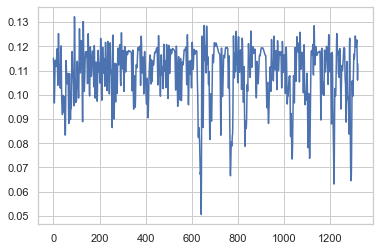

In [427]:
plt.plot(predictions) 

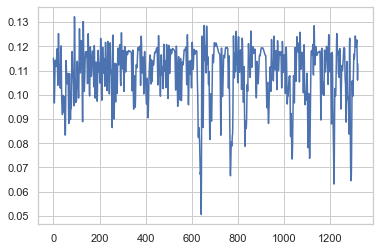

In [428]:
unscaled_predictions = scaler.inverse_transform(predictions)
plt.plot(unscaled_predictions) 

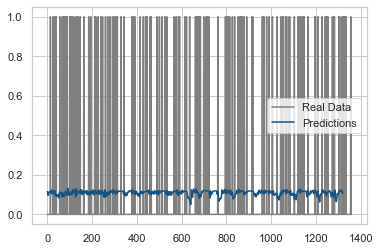

In [429]:
plt.plot(test_data, color = 'gray', label = "Real Data")
plt.plot(unscaled_predictions, color = '#135485', label = "Predictions")
plt.title('')
plt.legend() 

### Tuning RNN using GridSearchCV

In [452]:
def create_model():
    rnn = Sequential()
    rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
    rnn.add(Dropout(0.2))

    rnn.add(LSTM(units = 45, return_sequences = True))
    rnn.add(Dropout(0.2))

    rnn.add(LSTM(units = 45, return_sequences = True))
    rnn.add(Dropout(0.2))

    rnn.add(LSTM(units = 45))
    rnn.add(Dropout(0.2)) 

    # Output layer
    rnn.add(Dense(units = 1)) 
    # Compile model
    rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return rnn

# create model
rnn = KerasClassifier(model=create_model, verbose=0)

batch_size = [10, 20, 32, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=rnn, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_training_data, y_training_data)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

2022-12-29 20:51:48.884786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 20:51:48.884814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 20:51:48.887702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-12-29 21:53:08.503214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 21:56:08.230209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 21:57:01.247572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Best: 0.893347 using {'batch_size': 10, 'epochs': 10}
0.893347 (0.000255) with: {'batch_size': 10, 'epochs': 10}
0.893347 (0.000255) with: {'batch_size': 10, 'epochs': 50}
0.893347 (0.000255) with: {'batch_size': 10, 'epochs': 100}
0.893347 (0.000255) with: {'batch_size': 20, 'epochs': 10}
0.893347 (0.000255) with: {'batch_size': 20, 'epochs': 50}
0.893347 (0.000255) with: {'batch_size': 20, 'epochs': 100}
0.893347 (0.000255) with: {'batch_size': 32, 'epochs': 10}
0.893347 (0.000255) with: {'batch_size': 32, 'epochs': 50}
0.893347 (0.000255) with: {'batch_size': 32, 'epochs': 100}
0.893347 (0.000255) with: {'batch_size': 40, 'epochs': 10}
0.893347 (0.000255) with: {'batch_size': 40, 'epochs': 50}
0.893347 (0.000255) with: {'batch_size': 40, 'epochs': 100}
0.893347 (0.000255) with: {'batch_size': 60, 'epochs': 10}
0.893347 (0.000255) with: {'batch_size': 60, 'epochs': 50}
0.893347 (0.000255) with: {'batch_size': 60, 'epochs': 100}
0.893347 (0.000255) with: {'batch_size': 80, 'epochs': 1

#### Changing Loss Function

In [463]:
rnn = Sequential() 

rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45))
rnn.add(Dropout(0.2)) 
b
# Output layer
rnn.add(Dense(units = 1)) 
# Compile model
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32) 

Epoch 1/100
156/156 [==============================] - 6s 11ms/step - loss: 0.0963 - accuracy: 0.8930
Epoch 2/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0960 - accuracy: 0.8930
Epoch 3/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0958 - accuracy: 0.8930
Epoch 4/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0959 - accuracy: 0.8930
Epoch 5/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0961 - accuracy: 0.8930
Epoch 6/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0958 - accuracy: 0.8930
Epoch 7/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0958 - accuracy: 0.8930
Epoch 8/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0959 - accuracy: 0.8930
Epoch 9/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0960 - accuracy: 0.8930
Epoch 10/100
156/156 [==============================] - 2s 10ms/step - loss: 0.096

156/156 [==============================] - 2s 10ms/step - loss: 0.0955 - accuracy: 0.8930
Epoch 81/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0956 - accuracy: 0.8930
Epoch 82/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0956 - accuracy: 0.8930
Epoch 83/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0955 - accuracy: 0.8930
Epoch 84/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0956 - accuracy: 0.8930
Epoch 85/100
156/156 [==============================] - 2s 11ms/step - loss: 0.0956 - accuracy: 0.8930
Epoch 86/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0956 - accuracy: 0.8930
Epoch 87/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0955 - accuracy: 0.8930
Epoch 88/100
156/156 [==============================] - 2s 11ms/step - loss: 0.0955 - accuracy: 0.8930
Epoch 89/100
156/156 [==============================] - 2s 10ms/step - loss: 0.0955 - 

#### Changing amount of units and neurons

In [471]:
rnn = Sequential() 

rnn.add(LSTM(units = 60, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 60, return_sequences = True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 60))
rnn.add(Dropout(0.2)) 

# Output layer
rnn.add(Dense(units = 1)) 
# Compile model
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

rnn.fit(x_training_data, y_training_data, epochs = 50, batch_size = 32) 

Epoch 1/50
155/155 [==============================] - 5s 19ms/step - loss: 0.0963 - accuracy: 0.8933
Epoch 2/50
155/155 [==============================] - 3s 19ms/step - loss: 0.0958 - accuracy: 0.8933
Epoch 3/50
155/155 [==============================] - 3s 19ms/step - loss: 0.0956 - accuracy: 0.8933
Epoch 4/50
155/155 [==============================] - 3s 19ms/step - loss: 0.0954 - accuracy: 0.8933
Epoch 5/50
155/155 [==============================] - 3s 20ms/step - loss: 0.0955 - accuracy: 0.8933
Epoch 6/50
155/155 [==============================] - 3s 19ms/step - loss: 0.0956 - accuracy: 0.8933
Epoch 7/50
155/155 [==============================] - 3s 19ms/step - loss: 0.0957 - accuracy: 0.8933
Epoch 8/50
155/155 [==============================] - 3s 20ms/step - loss: 0.0955 - accuracy: 0.8933
Epoch 9/50
155/155 [==============================] - 3s 20ms/step - loss: 0.0955 - accuracy: 0.8933
Epoch 10/50
155/155 [==============================] - 3s 20ms/step - loss: 0.0955 - accura

### Using K-fold Cross Validation on testing splits

#### SVM

In [476]:
test_splits = [0.05, 0.10, 0.15, 0.20, 0.30]

for i in test_splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=101)
    
    # SVM using Cross Validation
    # train the model on train set
    svm_model = SVC(C=100, gamma=1, kernel='linear').fit(X_train, y_train)
    scores = cross_val_score(svm_model, X, y, cv=5)
    
    print(f"The SVM using testing split: {i}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    # print prediction results
    svm_predictions = svm_model.predict(X_test)
    print(classification_report(y_test, svm_predictions))

The SVM using testing split: 0.05
0.94 accuracy with a standard deviation of 0.02
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       293
           1       0.79      0.62      0.70        24

    accuracy                           0.96       317
   macro avg       0.88      0.81      0.84       317
weighted avg       0.96      0.96      0.96       317

The SVM using testing split: 0.1
0.94 accuracy with a standard deviation of 0.02
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       581
           1       0.91      0.79      0.85        52

    accuracy                           0.98       633
   macro avg       0.95      0.89      0.92       633
weighted avg       0.98      0.98      0.98       633

The SVM using testing split: 0.15
0.94 accuracy with a standard deviation of 0.02
              precision    recall  f1-score   support

           0       0.98      0.99      0.98   

#### GNB

In [477]:
test_splits = [0.05, 0.10, 0.15, 0.20, 0.30]

for i in test_splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=101)
    
    # GNB using Cross Validation
    # train the model on train set
    gnb_model = GaussianNB().fit(X_train, y_train)
    scores = cross_val_score(gnb_model, X, y, cv=5)
    
    print(f"The GNB using testing split: {i}")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    # print prediction results
    gnb_predictions = gnb_model.predict(X_test)
    print(classification_report(y_test, gnb_predictions))
    print("\n")

The GNB using testing split: 0.05
0.97 accuracy with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       293
           1       0.65      0.92      0.76        24

    accuracy                           0.96       317
   macro avg       0.82      0.94      0.87       317
weighted avg       0.97      0.96      0.96       317



The GNB using testing split: 0.1
0.97 accuracy with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       581
           1       0.69      0.96      0.81        52

    accuracy                           0.96       633
   macro avg       0.85      0.96      0.89       633
weighted avg       0.97      0.96      0.96       633



The GNB using testing split: 0.15
0.97 accuracy with a standard deviation of 0.00
              precision    recall  f1-score   support

           0       1.00      0.96      0.9